In [1]:
from pandas import read_csv, DataFrame, concat
from pandas import datetime
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [3]:
#load the dataset
# def parser(x):
def parser(x):
    return datetime.strptime('190'+x, '%Y/%m')

In [4]:
#data source from Google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
main_path = '/content/drive/MyDrive/ML Datasets/LSTM-dataset'
series = read_csv(main_path+'/shampoo-sales.csv')

In [ ]:
# Loading data from local 
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# #summarize first few rows
# print(series.head())
# series.describe()

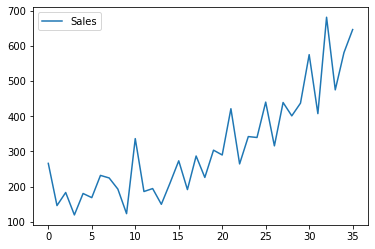

In [7]:
# line plot
series.plot()
pyplot.show()

In [ ]:

# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
print('train=',len(train),'test=', len(test))

train= 24 test= 12


In [ ]:
# walk forward validation
history = [x for x in train]
history

[266.0,
 145.9,
 183.1,
 119.3,
 180.3,
 168.5,
 231.8,
 224.5,
 192.8,
 122.9,
 336.5,
 185.9,
 194.3,
 149.5,
 210.1,
 273.3,
 191.4,
 287.0,
 226.0,
 303.6,
 289.9,
 421.6,
 264.5,
 342.3]

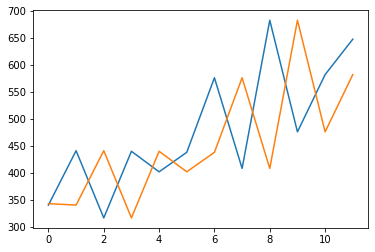

RMSE: 136.761


In [ ]:
predictions = list()
for i in range(len(test)):
    #make predictions
    predictions.append(history[-1])
    #observations
    history.append(test[i]) 
#report performance
rmse = sqrt(mean_squared_error(test, predictions))
#line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()
print('RMSE: %.3f' % rmse)

In [ ]:
#frame a sequence as a supervised learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff= list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

#inverse differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
        
# scale train and test data to [-1,1]     
def scale(train, test):
    #fit scaler
    scaler = MinMaxScaler(feature_rane=(-1,1))
    scaler = scaler.fit(train)
    #transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    #transform test
    test = test.reshape(test.shae[0], train.shape[1])
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled
# inverse scaling for a forecasted value
def inverse_scale(scaler, X,value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

#MAKE A ONE-STEP FORECAST
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size = batch_size)
    return yhat[0, 0]

In [ ]:
# transform to supervised learning
row_values = series.values
diff_values = difference(row_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
print(supervised.head())

supervised_values = supervised.values
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
    # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

NameError: name 'Series' is not defined